In [1]:
import cv2
# import Libraries
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, GlobalAveragePooling2D, multiply, Lambda, Dropout,BatchNormalization, Attention, Input
from tensorflow.python.ops.init_ops import he_normal
from keras.callbacks import EarlyStopping


In [2]:
# Define paths
train_dir = 'D:/deep_space/MV/Dataset_split_3/Train'
test_dir = 'D:/deep_space/MV/Dataset_split_3/Test'

In [3]:
# Load and preprocess the training data
input_shape = (256,256, 3)
batch_size=16

# Load and preprocess the test data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=[0.64, 1.0],
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.177)

'''
                                   rotation_range=20,  # 随机旋转图像（0-180度之间）
                                   width_shift_range=0.2,  # 随机水平平移图像
                                   height_shift_range=0.2,  # 随机垂直平移图像
                                   shear_range=0.2,  # 随机错切变换
                                   zoom_range=0.2,  # 随机缩放图像
                                   horizontal_flip=True,  # 随机水平翻转图像
                                   fill_mode='nearest',  # 用于填充新创建像素的方法
                                   brightness_range=[0.5, 1.5],

'''

                                   


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)


Found 274 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 60 images belonging to 4 classes.


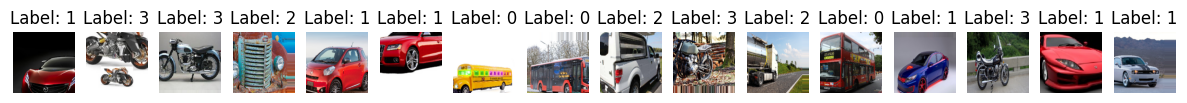

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
from keras.layers import Add, Activation, ReLU
def residual_block(inputs, num_channels, kernel_size=3, strides=1):
    # Convolutional layer 1
    x = Conv2D(num_channels, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    x = Conv2D(num_channels, (3, 3), padding='same', strides=strides, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Shortcut connection (identity mapping)
    if inputs.shape[-1] != num_channels or strides != 1:
        shortcut = Conv2D(num_channels, kernel_size=1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    
    # Ensure consistent shapes
    if inputs.shape[-1] != num_channels:
        shortcut = Conv2D(num_channels, kernel_size=1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Element-wise addition
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x


In [7]:
def first_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    
    att = Attention()([x, x])
    x = x + att
    
    return x


In [8]:
def second_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    
      
    att = Attention()([x, x])
    x = x + att
    
    return x


In [9]:
from tensorflow.python.keras.layers import Concatenate
from keras.backend import concatenate

def create_combined_model(input_shape=input_shape):
    inputs = Input(shape=input_shape)
    
    branch1 = first_Model(inputs)
    branch2 = second_Model(inputs)
    
    x = concatenate([branch1, branch2], axis=-1)
    
    att = Attention()([x, x])
    x = x + att
#     x = Conv2D(4096, (1,1), activation='relu')(x)

    # x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage

combined_model = create_combined_model(input_shape)

In [10]:
#computing attention weights. Each element in the input tensor x will be assigned a weight by this dense layer
# attention = Dense(1, activation='tanh')(x)

In [11]:
# Reshape attention to have dimensions (-1, 1, 1)
# attention = Reshape((-1, 1, 1))(attention)

In [12]:
# Apply the attention weights element-wise to the original feature representation (x) 
# attention = multiply([x, attention])

In [13]:
# The attention weights are summed along the channel axis (-2) to produces a single attention value 
# attention = Lambda(lambda x: K.sum(x, axis=-2))(attention)

In [14]:
# The attention values are expanded along a new axis (-1)
# attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)

In [15]:
# computes the average of all the values along each channel
# attention = GlobalAveragePooling2D()(attention)

In [16]:
# merged = Dense(4, activation='softmax')(attention)

In [17]:
# Create the new model
# model = Model(inputs=base_model.input, outputs=merged)
# model = Model(inputs=base_model.input, outputs=output)

In [18]:
from keras.losses import SparseCategoricalCrossentropy


def custom_sparse_categorical_crossentropy(y_true, y_pred):
    # Convert one-hot encoded labels to integer labels
    y_true = tf.argmax(y_true, axis=-1)
    
    # Use SparseCategoricalCrossentropy with integer labels
    loss = SparseCategoricalCrossentropy()(y_true, y_pred)
    
    return loss

In [19]:
# Display the model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [20]:
# Compile the model
combined_model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
              )

In [21]:
# Train the model
history = combined_model.fit(train_generator, validation_data=(val_generator), epochs=40)

Epoch 1/40
18/18 [==============================] - 30s 1s/step - loss: 3.9131 - accuracy: 0.2664 - val_loss: 1.5794 - val_accuracy: 0.2456
Epoch 2/40
18/18 [==============================] - 22s 1s/step - loss: 1.4780 - accuracy: 0.2555 - val_loss: 1.3396 - val_accuracy: 0.4035
Epoch 3/40
18/18 [==============================] - 21s 1s/step - loss: 1.3493 - accuracy: 0.3285 - val_loss: 1.3785 - val_accuracy: 0.2982
Epoch 4/40
18/18 [==============================] - 22s 1s/step - loss: 1.3449 - accuracy: 0.3321 - val_loss: 1.2494 - val_accuracy: 0.4211
Epoch 5/40
18/18 [==============================] - 22s 1s/step - loss: 1.2729 - accuracy: 0.3577 - val_loss: 1.3760 - val_accuracy: 0.2632
Epoch 6/40
18/18 [==============================] - 22s 1s/step - loss: 1.2600 - accuracy: 0.3686 - val_loss: 1.1777 - val_accuracy: 0.4561
Epoch 7/40
18/18 [==============================] - 22s 1s/step - loss: 1.1800 - accuracy: 0.4562 - val_loss: 1.0998 - val_accuracy: 0.4561
Epoch 8/40
18/18 [==

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 18s 977ms/step - loss: 0.5874 - accuracy: 0.8029
Test Accuracy: 0.8029196858406067
Test loss: 0.5874208807945251


In [23]:
test_loss, test_accuracy = combined_model.evaluate(val_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

4/4 [==============================] - 4s 852ms/step - loss: 0.8028 - accuracy: 0.7719
Test Accuracy: 0.7719298005104065
Test loss: 0.8027567863464355


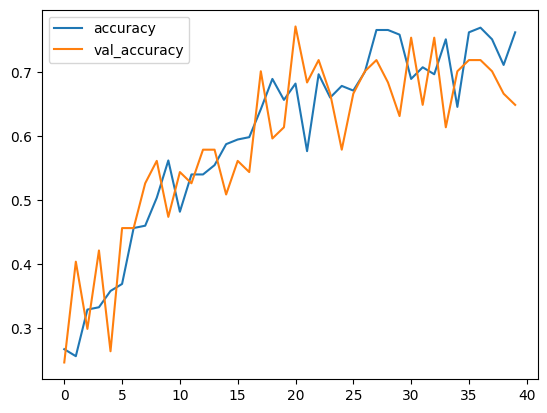

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

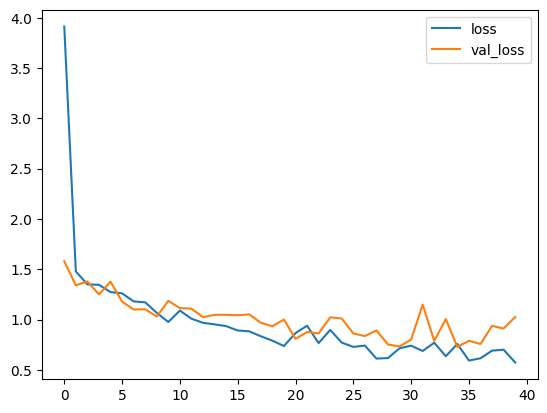

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()